In [2]:
import shapefile
import netCDF4 as nc
import pyproj
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (15.,10)

In [3]:
#plt.figure(figsize=(20,20))
#plt.imshow(total_soil[0,:],origin='bottom')

In [4]:

SOIL_DIR='/prj/GREENHOUSE/SOIL_PROPERTIES/datasets/England_Wales_Soil_Data/LDE16_12_SRUC_Tarsitano/'
shp_file=SOIL_DIR+'Spatial Soil Data/NATMAP1000.shp'
Hyd_LUT_file=SOIL_DIR+'Tabular Attribute Data/HORIZONhydraulics_V2.csv'
Cst_LUT_file=SOIL_DIR+'Tabular Attribute Data/HORIZONfundamentals_V2.csv'

LatLon_file='/users/eow/edwcom/CHESS/chess_landcover_2000.nc'

OUTFILE=SOIL_DIR+'EnW_Soil_WeightedComposition_CHESSgrid.nc'

fill_value=-9999.0

In [5]:
# LU Groups (Correspond to CHESS classes in  CHESS_LU_idx
LU_groups=['PG','AR','OT']  #['AR'] # 
CHESS_LU_idx=[[2],[4],[0,1,3,5,6,7]]  # range(8)  #
nLU=len(LU_groups)


#read in latlon/xy data from chess_landcover
LLinf=nc.Dataset(LatLon_file,'r')
lats=LLinf.variables['lat'][:]
lons=LLinf.variables['lon'][:]
landcover=LLinf.variables['frac'][:]
x=LLinf.variables['x'][:]
y=LLinf.variables['y'][:]
nx,ny=len(x),len(y)
#LLinf.close()
CHESS_maxLC=np.ma.masked_array(np.argmax(landcover,axis=0), \
                               mask=landcover.mask[0,:,:],  \
                               fill_value=fill_value )
CHESS_maxLC.data[CHESS_maxLC.mask==True]=fill_value

LAND_MASK=CHESS_maxLC.mask

# Create Land Use Map correpsonding to the soil properties land uses:
#  0 = C3 Grass = 'PG' (Permenant Grass)
#  1 = Crop = 'AR' (Arable)
#  2 = Everything Else = 'OT' (Other)
CHESS_LU_map = np.zeros_like(landcover[:nLU,:])
for iLU in range(nLU):
    CHESS_LU_map[iLU,:,:]=np.sum(landcover[CHESS_LU_idx[iLU],:],axis=0)



In [6]:
print(nLU)


3


In [7]:
CH_soil_depths=np.array([0.1,0.35,1.0,3.0])
CH_mean_soil_depths=np.array([0.05,0.225,0.675,2.0])
#nx=len(x)
#ny=len(y)
nSD=len(CH_soil_depths)
#fill_value=-9999.0

Const_in_names=['SAND_TOTAL','SILT', 'CLAY', 'OC', 'PH','BULK_DENSITY'] #'SAND_FINE', 'SAND_MED', 'SAND_COARSE',
Const_out_names=['sand','silt','clay','org_carb','ph','Bulk_Density'] #'sand_fine','sand_med','sand_coarse',

#CHESS_SoilConst={ varname: np.zeros([nSD,ny,nx])+fill_value \
#                    for varname in Const_out_names  }


In [8]:
#print(Cst_LUT_file)
#Read in Cst-LUT
Cst_LUT_lines=[line[:-1] for line in open(Cst_LUT_file).readlines()]
Hyd_LUT_lines=[line[:-1] for line in open(Hyd_LUT_file).readlines()]

print(Cst_LUT_lines[0])
print(Hyd_LUT_lines[0])

Cst_headers=Cst_LUT_lines.pop(0).split(',')
Hyd_headers=Hyd_LUT_lines.pop(0).split(',')

print('Cst_Headers = ',Cst_headers)
print('Hyd_Headers = ',Hyd_headers)

LUT_Dict={hdr:[] for hdr in Cst_headers+Hyd_headers}

for Cst_line,Hyd_line in zip(Cst_LUT_lines,Hyd_LUT_lines):
    Cst_vals=Cst_line.split(',')
    Hyd_vals=Hyd_line.split(',')
    # Unless there are values for sand, silt, clay, OC and ph, throw line away
    if (Cst_vals[7]!='')&(Cst_vals[11]!='')&(Cst_vals[12]!='')&(Cst_vals[13]!='')&(Cst_vals[14]!='')\
            &(Hyd_vals[7]!=''):
        # Append Constituents to relevant list
        for hdr,val in zip(Cst_headers,Cst_vals):
            if val=='':
                val='-1'
            LUT_Dict[hdr].append(val)
        # Append Hydraulics to list (missing out the series names and ids etc.)
        for hdr,val in zip(Hyd_headers[7:],Hyd_vals[7:]):
            if val=='':
                val='-1'
            LUT_Dict[hdr].append(val)

headers_to_float=['UPPER_DEPTH', 'LOWER_DEPTH', 'SAND_TOTAL', \
                  'SAND_FINE', 'SAND_MED', 'SAND_COARSE', 'SILT', 'CLAY', 'OC', 'PH', \
                  'BULK_DENSITY', 'PARTICLE_DENSITY', 'TOTAL_POROSITY', \
                  'THV0', 'THV1', 'THV5', 'THV10', 'THV40', 'THV200', 'THV1500', \
                  'KSAT_SUBVERT', 'KSAT_LAT', \
                  'VG_TH_S', 'VG_TH_R', 'VG_ALPHA', 'VG_N', 'VG_M', \
                  'BC_TH_S', 'BC_ALPHA', 'BC_BETA', \
                 ]

for hdr in headers_to_float:
    LUT_Dict[hdr]=[float(val) for val in LUT_Dict[hdr]]
for hdr in LUT_Dict:
    LUT_Dict[hdr]=np.array(LUT_Dict[hdr])
    
LUT_Dict['MEAN_DEPTH']=(LUT_Dict['LOWER_DEPTH']+LUT_Dict['UPPER_DEPTH'])/200.
    
    

HORID,SERIES,SERIES_NAME,LU_GROUP,DESIGNATION,UPPER_DEPTH,LOWER_DEPTH,SAND_TOTAL,SAND_FINE,SAND_MED,SAND_COARSE,SILT,CLAY,OC,PH,SAND_TOTAL_QA,SAND_FINE_QA,SAND_MED_QA,SAND_COARSE_QA,SILT_QA,CLAY_QA,OC_QA,PH_QA
HORID,SERIES,SERIES_NAME,LU_GROUP,DESIGNATION,UPPER_DEPTH,LOWER_DEPTH,BULK_DENSITY,PARTICLE_DENSITY,TOTAL_POROSITY,THV0,THV1,THV5,THV10,THV40,THV200,THV1500,KSAT_SUBVERT,KSAT_LAT,VG_TH_S,VG_TH_R,VG_ALPHA,VG_N,VG_M,BC_TH_S,BC_ALPHA,BC_BETA
Cst_Headers =  ['HORID', 'SERIES', 'SERIES_NAME', 'LU_GROUP', 'DESIGNATION', 'UPPER_DEPTH', 'LOWER_DEPTH', 'SAND_TOTAL', 'SAND_FINE', 'SAND_MED', 'SAND_COARSE', 'SILT', 'CLAY', 'OC', 'PH', 'SAND_TOTAL_QA', 'SAND_FINE_QA', 'SAND_MED_QA', 'SAND_COARSE_QA', 'SILT_QA', 'CLAY_QA', 'OC_QA', 'PH_QA']
Hyd_Headers =  ['HORID', 'SERIES', 'SERIES_NAME', 'LU_GROUP', 'DESIGNATION', 'UPPER_DEPTH', 'LOWER_DEPTH', 'BULK_DENSITY', 'PARTICLE_DENSITY', 'TOTAL_POROSITY', 'THV0', 'THV1', 'THV5', 'THV10', 'THV40', 'THV200', 'THV1500', 'KSAT_SUBVERT', 'KSAT_LAT', 'VG_

In [9]:
SF=shapefile.Reader(shp_file)
ShRcs=SF.shapeRecords()


In [10]:
#fields=SF.fields
#print(fields)
field_names=[field[0] for field in SF.fields]
field_names.pop(0)
#print(field_names)

Eindex=field_names.index('EAST_1K')
Nindex=field_names.index('NORTH_1K')
#print(Eindex,Nindex)
             

In [16]:
print(LU_groups)
print(CHESS_LU_map.shape)

['PG', 'AR', 'OT']
(3, 1057, 656)


In [17]:
#ShRc=ShRcs[0]
#print(ShRc.record[Eindex])
#print(np.float(ShRc.record[Eindex]))
#choose max number of series
nSERIES=10

CHESS_SoilConst={ varname: np.zeros([nSD,ny,nx])+fill_value \
                    for varname in Const_out_names  }
#SERIES_PC_map=np.zeros([ny,nx])
#SERIES_PC_map2=np.zeros([ny,nx])
#LU_groups=['AR'] # ['PG','AR','OT']
for iShRc in range(len(ShRcs)):
    ShRc=ShRcs[iShRc]
    x_index=int(float(ShRc.record[Eindex])/1000.)
    y_index=int(float(ShRc.record[Nindex])/1000.)
    
    #Check to see if location is a CHESS Land Point
    if (LAND_MASK[y_index,x_index]==True):
        continue
    
    #Create Dictionary to store point data in
    Point_Data={ varname: np.zeros([nSD]) for varname in Const_out_names  }
    
    # Collate Soil Series names and percetage cover
    SERIES_dict={'names':[],'pc':[]}
    for iS in range(nSERIES):
        Sname_index=int(iS*2.)+2
        Spc_index=Sname_index+1
        if (ShRc.record[Spc_index]!=None)&\
            (ShRc.record[Sname_index] in LUT_Dict['SERIES_NAME']):
            SERIES_dict['names'].append(ShRc.record[Sname_index])
            SERIES_dict['pc'].append(ShRc.record[Spc_index])
    # Convert to numpy arrays for searching
    SERIES_dict['names']=np.array(SERIES_dict['names'])
    SERIES_dict['pc']=np.array(SERIES_dict['pc'])
    # Normalise percentages (i.e. ignoring the small and 'other' components)
    SERIES_dict['pc']=SERIES_dict['pc']/np.sum(SERIES_dict['pc'])
    
    # Count for Soil Types in this gridcell
    SOIL_SUM_COUNT=0
    SERIES_percent=0
    # Loop over soil series for location
    for iS in range(len(SERIES_dict['names'])):
        #SERIES_percent+=SERIES_dict['pc'][iS]
        #SERIES_PC_map[y_index,x_index]+=SERIES_dict['pc'][iS]
        
        # Loop over LU groups:
        LU_fraction=0
        
        #Create Dictionary to store series data in
        Series_Data={ varname: np.zeros([nSD]) for varname in Const_out_names  }
        
        for iLU in range(len(LU_groups)):
            # if Landuse not relevent then move on
            if CHESS_LU_map[iLU,y_index,x_index]==0:
                continue
            
            LU=LU_groups[iLU]
            # index locations which have correct series
            #print(SERIES_dict['names'][iS],LU)
            LU_S_index= np.where((LUT_Dict['LU_GROUP']==LU)      & \
                                 (LUT_Dict['SERIES_NAME']==SERIES_dict['names'][iS]))[0]
            #if there is no match LU and Soil Series then continue:
            #print(LU_S_index)
            if len(LU_S_index)==0:
                continue
            
            if iLU==0:
                SERIES_percent+=SERIES_dict['pc'][iS]
                #SERIES_PC_map[y_index,x_index]+=SERIES_dict['pc'][iS]

            LU_fraction+=CHESS_LU_map[iLU,y_index,x_index]
            
            # loop over output soil depths
            for iSD in range(nSD):
                # find closest input SD
                if (len(LU_S_index)==0):
                    print(LU, SERIES_dict['names'][iS])
                    print(ShRc.record)
                SD_index=np.argmin(np.abs( LUT_Dict['MEAN_DEPTH'][LU_S_index] \
                                          -CH_mean_soil_depths[iSD]) )
                # INDEX of the closest soil depth for the series and LU
                INDEX=LU_S_index[SD_index]
                # Loop over output parameters
                for inname,outname in zip(Const_in_names,Const_out_names):
                    #for each param, at each soil depth, sum the weighted components
                    Series_Data[outname][iSD]+= \
                      (LUT_Dict[inname][INDEX]*SERIES_dict['pc'][iS]) \
                    * CHESS_LU_map[iLU,y_index,x_index]
                 
        # Normalise for any absent Land Uses if required
        if (LU_fraction>0.4):
            SOIL_SUM_COUNT+=1
            for outname in Const_out_names:
                #for each param, at each soil depth, sum the weighted components
                Point_Data[outname] += Series_Data[outname]/LU_fraction
        else:
            continue
            
    #SERIES_PC_map2[y_index,x_index]=SERIES_percent
    # Normalise to total series percentage
    if (SERIES_percent>0.4):
        for outname in Const_out_names:
            #for each param, at each soil depth, sum the weighted components
            Point_Data[outname] /= (SERIES_percent)
    else:
        SOIL_SUM_COUNT=0
    
    # If no Soil FOund, reset to fill value
    if SOIL_SUM_COUNT!=0:
        for inname,outname in zip(Const_in_names,Const_out_names):
            #for each param, at each soil depth, sum the weighted components
            CHESS_SoilConst[outname][:,y_index,x_index]=Point_Data[outname]



In [19]:
for name in CHESS_SoilConst:
    print(name)
    CHESS_SoilConst[name]=np.ma.masked_equal(CHESS_SoilConst[name],fill_value)

clay
org_carb
sand
Bulk_Density
silt
ph


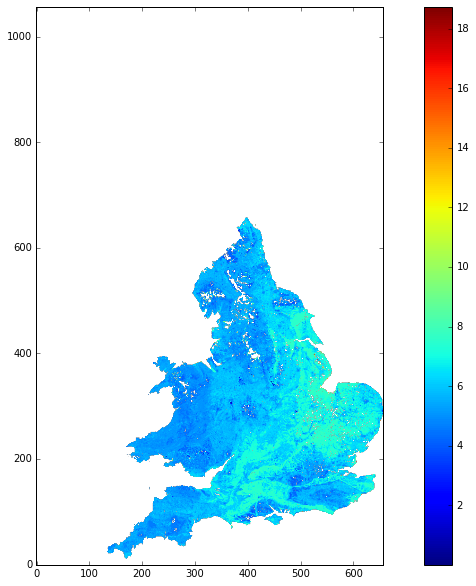

In [20]:

plt.imshow(CHESS_SoilConst['ph'][0,:],origin='bottom')
plt.colorbar()

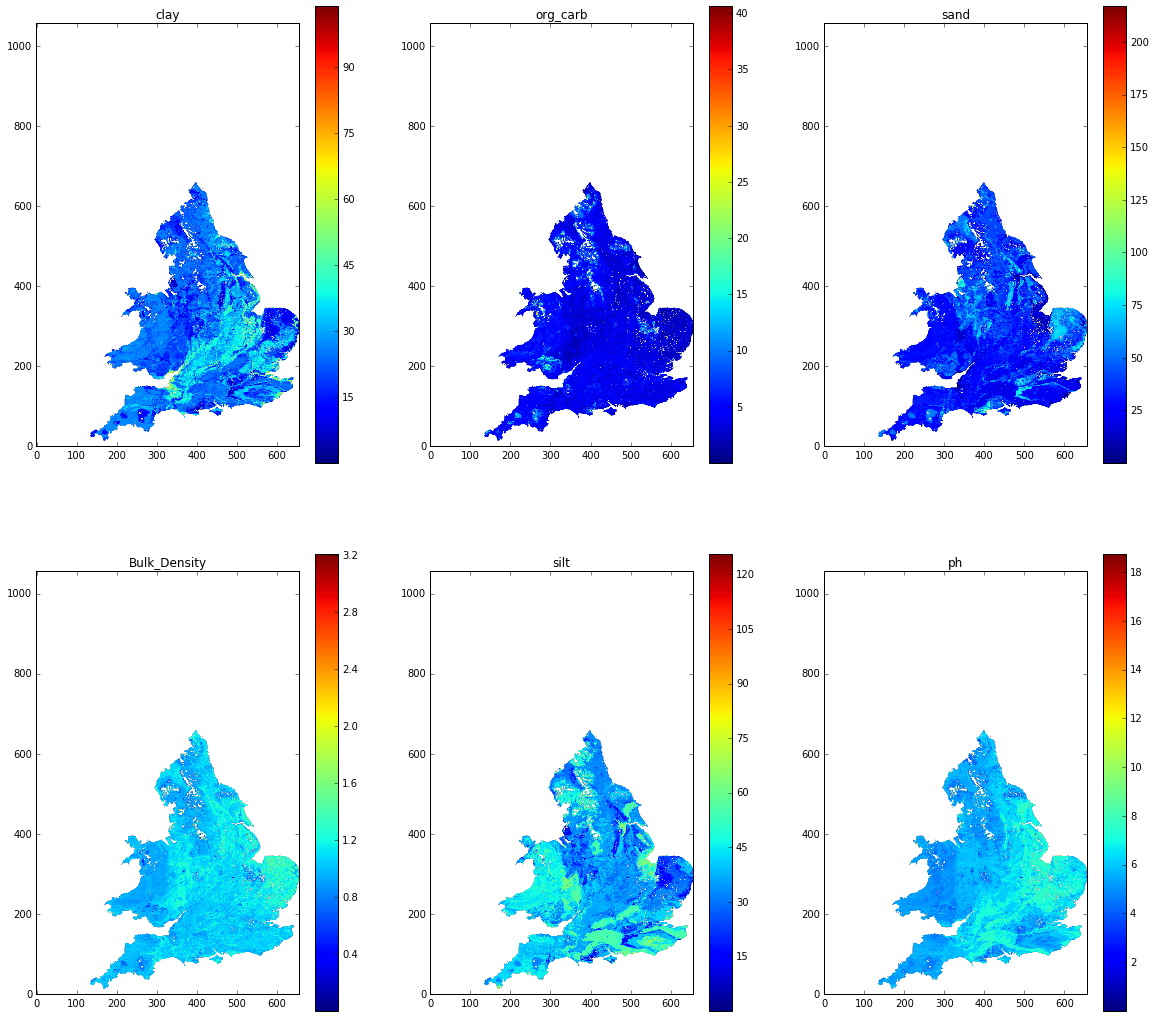

In [21]:
plt.figure(figsize=(20,18))
iSUB=1
for name in CHESS_SoilConst:
    plt.subplot(2,3,iSUB)
    plt.imshow(CHESS_SoilConst[name][0,:],origin='bottom') #,vmax=100,vmin=0)
    plt.colorbar()
    plt.title(name)
    iSUB+=1
    if iSUB>6:
        break

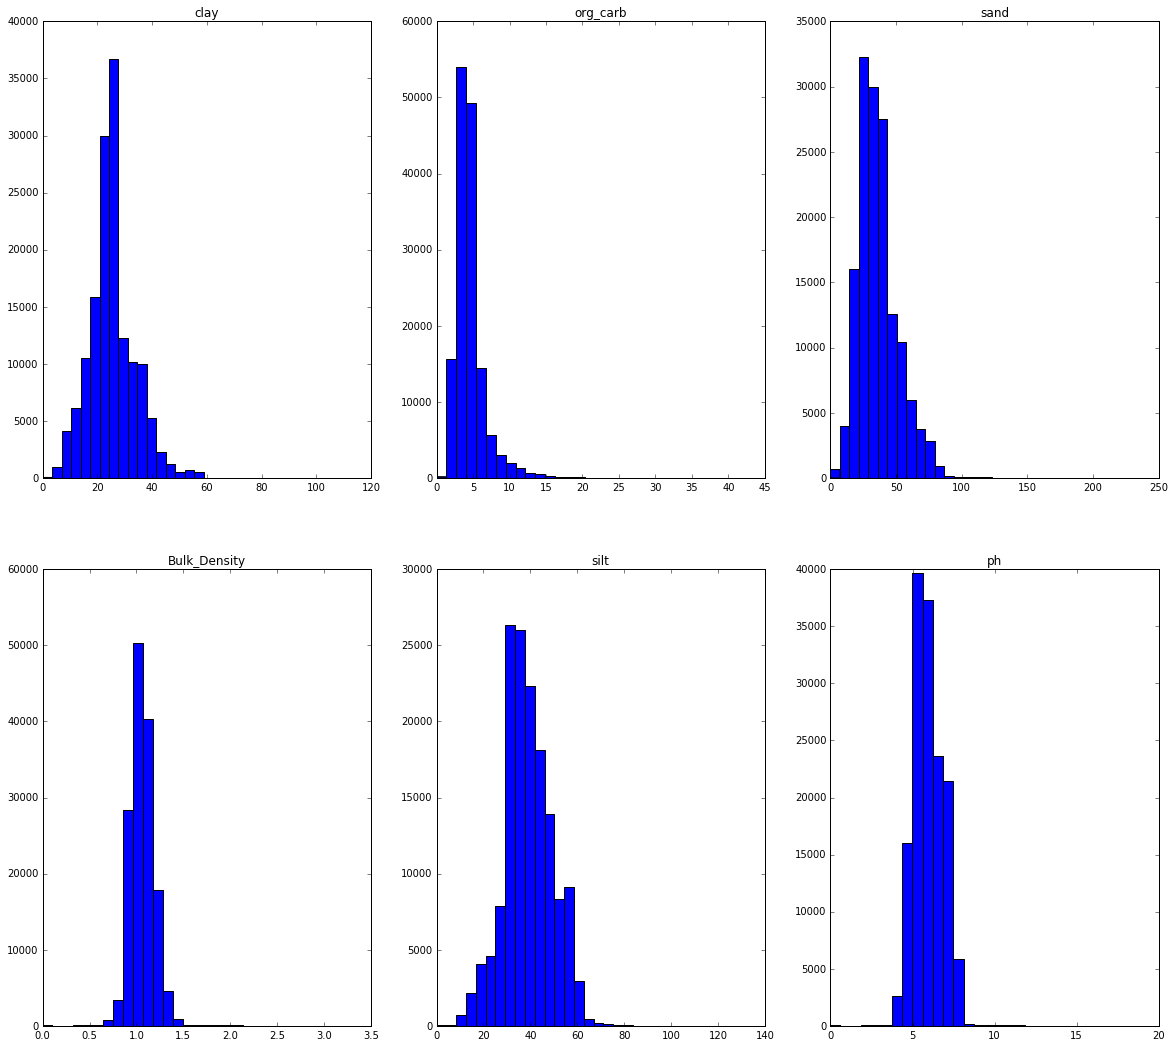

In [22]:
plt.figure(figsize=(20,18))
iSUB=1
for name in CHESS_SoilConst:
    plt.subplot(2,3,iSUB)
    histdata=CHESS_SoilConst[name][0,:]
    plt.hist(histdata[histdata.mask==False].flatten(),bins=30)
    plt.title(name)
    iSUB+=1
    if iSUB>6:
        break

In [23]:

#total_soil=CHESS_SoilConst['clay']+CHESS_SoilConst['silt']+CHESS_SoilConst['sand']#
#
#plt.figure(figsize=(10,10))
#plt.imshow(total_soil[0,:],origin='bottom')
#plt.colorbar()


In [24]:
total_soil=CHESS_SoilConst['clay']+CHESS_SoilConst['silt']+CHESS_SoilConst['sand']
for name in ['sand','silt','clay']:
    CHESS_SoilConst[name] = CHESS_SoilConst[name] * 100. / total_soil
    

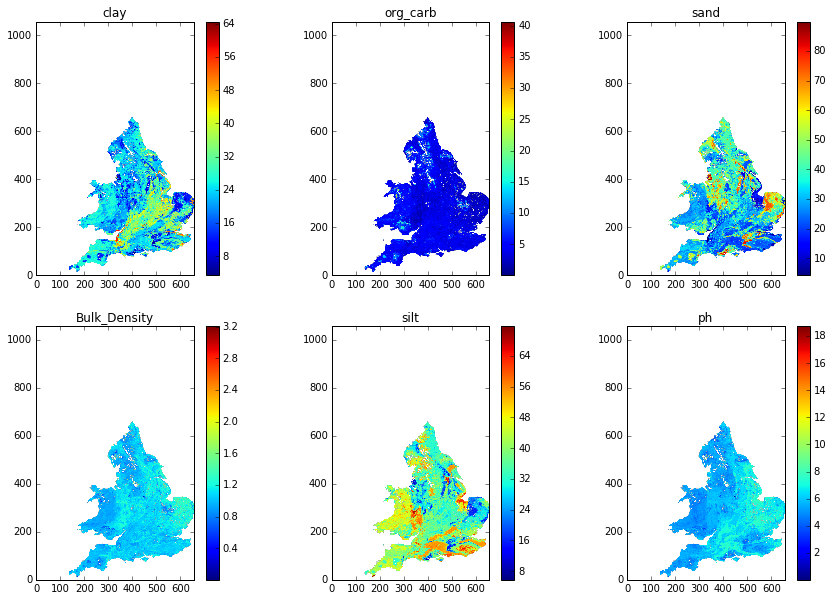

In [25]:
#plt.figure(figsize=(10,10))
iSUB=1
for name in CHESS_SoilConst:
    plt.subplot(2,3,iSUB)
    plt.imshow(CHESS_SoilConst[name][0,:],origin='bottom')
    plt.colorbar()
    plt.title(name)
    iSUB+=1

In [26]:

###############################################################
# Output data to netCDF file:
###############################
outf=nc.Dataset(OUTFILE,'w')

# Create Dimensions
outf.createDimension('x',nx)
outf.createDimension('y',ny)
outf.createDimension('z',nSD)

# write out dimension variables
for var in ['x','y']:
    outvar=outf.createVariable(var,'float32',(var))
    for att in LLinf.variables[var].ncattrs():
        outvar.setncattr(str(att),LLinf.variables[var].getncattr(str(att)))
    outvar[:]=LLinf.variables[var][:]

outvar=outf.createVariable('z','float32',('z'))
outvar.units='m'
outvar.long_name='lower soil depth'
outvar[:]=CH_soil_depths

# Loop around soil parameters and 
for var in CHESS_SoilConst:
    outvar=outf.createVariable(var,'float32',('z','y','x'),fill_value=fill_value)
    if var=='ph':
        outvar.units='pH'
    else:
        outvar.units='percent'
    outvar[:]=CHESS_SoilConst[var]
    
outf.close()
